<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-rag-agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_groq langchain langgraph langchain_community sentence_transformers tavily-python tiktoken langchainhub chromadb

# LangGraph RAG agent with Llama 3

Previously, we showed how to build simple agents with LangGraph and Llama 3.

Now, we'll pick a more advanced use-case: advanced RAG.

## Ideas

We'll combine ideas from three RAG papers into a RAG agent:

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

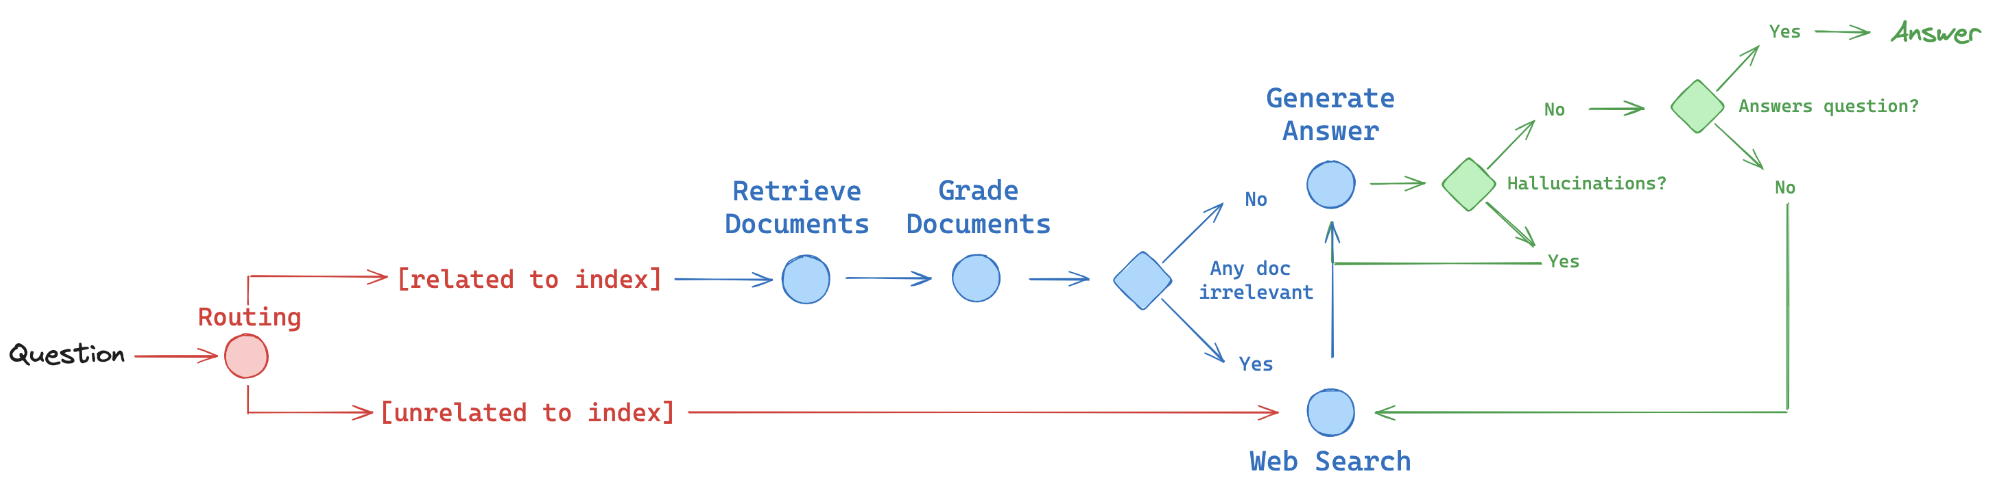

Note that this will incorperate [a few general ideas for agents](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/):

- **Reflection**: The self-correction mechanism is a form of reflection, where the LangGraph agent reflects on its retrieval and generations
- **Planning**: The control flow laid out in the graph is a form of planning 
- **Tool use**: Specific nodes in the control flow (e.g., web search) will use tools

## Models

### LLM

We can use one of the providers that (1) offer Llama 3 and (2) [provide structure outputs](https://python.langchain.com/docs/modules/model_io/chat/structured_output/).

Here, we use [Groq](https://groq.com/).

### Tracing

```
### Tracing (optional)
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'LANGCHAIN_API_KEY'
```

### Search

Uses [Tavily](https://tavily.com/#api)m for web search.

In [ ]:
### LLMs
import os

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'LANGCHAIN_API_KEY'

os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'
os.environ['GROQ_API_KEY'] = 'YOUR_GROQ_API_KEY'

In [ ]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=HuggingFaceEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [ ]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call 
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "Who will the Bears draft first in the NFL draft?"}))
print(question_router.invoke({"question": "What are the types of agent memory?"}))### Index

In [ ]:
### Retrieval Grader 

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

In [ ]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(temperature=0, model="llama3-70b-8192")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

In [ ]:
### Hallucination Grader 

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# LLM with function call 
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt 
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
### Answer Grader 

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt 
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question,"generation": generation})

In [ ]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [ ]:
from typing_extensions import TypedDict
from typing import List
from langchain.schema import Document

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[Document]



### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})  
    if source.datasource == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score.score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

In [ ]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [ ]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

Trace: 

https://smith.langchain.com/public/2babc6ec-a243-40d0-844b-5e6b40f70fc9/r